# Thermoelasticity

This example is implemented in the Python file <a href="thermoelasticity.py" target="_blank">thermoelasticity.py</a> and it illustrates how to:

- Use the solution of one PDE as the input for another PDE.

## Equation and problem definition

We consider linear deformation of a 2D isotropic elastic material due to thermal loads. A square-shaped sample is clamped on the left ($\Gamma_l$) and right ($\Gamma_r$) boundaries and is free to move on the top ($\Gamma_t$) and bottom ($\Gamma_b$) boundaries. The sample is in contact with heath baths that are at temperature $T_0=0$ on the left and right boundaries and at temperature $T_1=1$ on the top and bottom boundaries.
<div align="center">    
    <img src="figs/thermoelasticity_domain.png" style="width: 300px;"/>
</div>

The equilibrium temperature profile $T$, where temperature is measured relative to some reference temperature, can be obtained from the Fourier's law
$$\nabla \cdot (k \nabla T)=0,$$
where $k=1$ is the material conductivity. In FEniCS, we are going to solve this PDE using the weak form
$$\int_\Omega d{\bf x}\ [\nabla \cdot (k \nabla T)] \delta T=-\int_\Omega d{\bf x}\ k \nabla T \cdot \nabla \delta T=0.$$

To calculate the total deformation we have to consider both the thermal expansion and elastic deformation. Thermal expansion of material can be described with *thermal strains*
$$\epsilon^{th}_{ij} = \alpha T \delta_{ij},$$
where $\alpha=0.1$ is the thermal expansion coefficient. The total strain tensor $\epsilon^{tot}_{ij}$ thus has contributions from the elastic deformation and from thermal strains
$$\epsilon^{tot}_{ij} = \epsilon^{el}_{ij} + \epsilon^{th}_{ij} = \frac{1}{2} \left(\partial_i u_j + \partial_j u_i\right),$$
where $u_i$ are displacements. Only the elastic part of deformation producess stresses
$$\sigma_{ij} = 2 \mu \epsilon^{el}_{ij} + \lambda \epsilon^{el}_{kk} \delta_{ij},$$
where $\lambda$ and $\mu$ are the 2D Lamé constants that can be expressed in terms of the 2D Young's modulus $E$ and the Poisson's ratio $\nu$ as $\mu=E/[2(1+\nu)]$ and $\lambda = E \nu/(1-\nu^2)$. In this example, we use $E=1$ and $\nu=0.4$. Deformation of material can then be calculated by minimizing the total elastic energy
$$E_{el}[u_i]=\int_\Omega d{\bf x} \ \frac{1}{2} \sigma_{ij} \epsilon^{el}_{ij}.$$

## Implementation

In order to use FEniCS, we need to import several packages.

In [1]:
from __future__ import print_function
from fenics import *
from mshr import *
import matplotlib.pyplot as plt

Create mesh for a square-shaped sample

d =  2


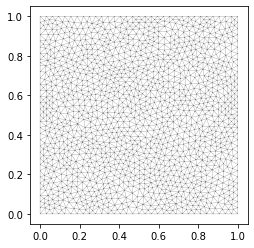

In [2]:
# create square mesh
N = 30
L = 1
domain = Rectangle(Point(0.,0.),Point(L,L))
mesh = generate_mesh(domain, N)
d = mesh.topology().dim() # dimensionality of the problem
print("d = ",d)
plot(mesh,linewidth=0.3)
plt.show()

Define material properties

In [3]:
# elastic constants
E = 1
nu = 0.4
mu = E/2/(1+nu)
Lambda = E*nu/(1-nu*nu)

# thermal expansion coefficient
alpha = 0.1
# material conductivity
k = 1

Define the function space, the function for the temperature field $T$ and the test function $\delta T$.

In [4]:
#define function space, temperature function T, and test function dT
degreeElements = 1
FS = FunctionSpace(mesh, 'Lagrange', degreeElements)
T  = Function(FS)
delta_T = TestFunction(FS)

Impose Dirichlet boundary conditions for the temperature field.

In [5]:
# temperatures at the boundaries
T0 = 0
T1 = 1

#define left, right, top, bottom boundaries
def left_boundary(x, on_boundary):
    return on_boundary and near(x[0],0);
def right_boundary(x, on_boundary):
    return on_boundary and near(x[0],L);
def top_boundary(x, on_boundary):
    return on_boundary and near(x[1],L);
def bottom_boundary(x, on_boundary):
    return on_boundary and near(x[1],0);

# impose Dirichlet boundary conditions for temperature
bc_T_left   = DirichletBC(FS, Constant(T0), left_boundary)
bc_T_right  = DirichletBC(FS, Constant(T0), right_boundary)
bc_T_top    = DirichletBC(FS, Constant(T1), top_boundary)
bc_T_bottom = DirichletBC(FS, Constant(T1), bottom_boundary)

bc_T = [bc_T_left, bc_T_right, bc_T_top, bc_T_bottom]

Solve the PDE for the temperature field
$$\int_\Omega d{\bf x}\ k \nabla T \cdot \nabla \delta T=0.$$

In [6]:
# solve for the temperature field
Res_T = k*dot(grad(T),grad(delta_T))*dx
solve(Res_T == 0, T, bc_T)

Plot the temperature field and export it for the visualization in <a href="https://www.paraview.org/" target="_blank">ParaView</a>.

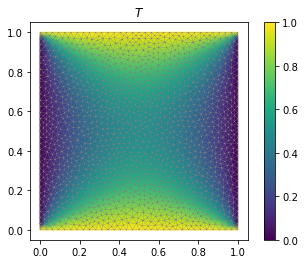

In [7]:
# plot temperature field
c = plot(T,mode='color',title='$T$')
plt.colorbar(c)
plot(mesh,linewidth=0.3)
plt.show()

# save temperature field
T.rename("temperature","")
fileT = File("data/temperature.pvd");
fileT << T;

Define the vector function space, the function for displacements $u$ and the test function $v$.

In [8]:
#define vector function space, displacements function u, and test function v
VFS = VectorFunctionSpace(mesh, 'Lagrange', degreeElements)
u  = Function(VFS)
v  = TestFunction(VFS)

Impose clamped boundary conditions on the left and right boundaries

In [9]:
#clamped boundary conditions on the left and right boundaries
bc_u_left  = DirichletBC(VFS, Constant((0.,0.)), left_boundary)
bc_u_right = DirichletBC(VFS, Constant((0.,0.)), right_boundary)

bc_u = [bc_u_left, bc_u_right]

Define the elastic strain and stress tensors
$$\begin{align}
 \epsilon^{el}_{ij} &= \frac{1}{2} \left(\partial_i u_j + \partial_j u_i\right)- \alpha T \delta_{ij},\\
\sigma_{ij} &= 2 \mu \epsilon^{el}_{ij} + \lambda \epsilon^{el}_{kk} \delta_{ij},
\end{align}$$
where we take into account thermal expansion.

In [10]:
# define total strain
def epsilon_tot(u):
    return sym(grad(u))
# define elastic strain
def epsilon_elastic(u,T):
    return epsilon_tot(u) - alpha*T*Identity(d)
# define stress
def sigma(u,T):
    return 2*mu*epsilon_elastic(u,T) + Lambda*tr(epsilon_elastic(u,T))*Identity(d)

Minimize the elastic energy
$$E_{el}[u_i]=\int_\Omega d{\bf x} \ \frac{1}{2} \sigma_{ij} \epsilon^{el}_{ij},$$
and impose Dirichlet boundary conditions on the two clamped ends.

In [11]:
# elastic energy functional
Energy = 1/2*inner(sigma(u,T),epsilon_elastic(u,T))*dx

# solve for the displacement field
Res_u = derivative(Energy, u, v)
solve(Res_u == 0, u, bc_u)

# calculate elastic energy
print("Energy = ",assemble(Energy))

Energy =  0.0018128029753234807


Export displacements $\bf u$ and von Mises stress for visualization in <a href="https://www.paraview.org/" target="_blank">ParaView</a>.

In [12]:
# export displacements
u.rename("displacements","")
fileD = File("data/displacements.pvd");
fileD << u;

# calculate and export von Mises stress
devStress = sigma(u,T) - (1./d)*tr(sigma(u,T))*Identity(d)  # deviatoric stress
von_Mises = project(sqrt(3./2*inner(devStress, devStress)), FS)
von_Mises.rename("von Mises","")
fileS = File("data/vonMises_stress.pvd");
fileS << von_Mises;

## Complete code

d =  2


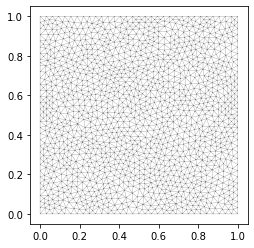

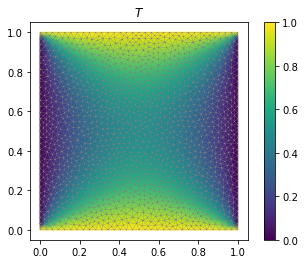

Energy =  0.0018128029753234807


In [13]:
from __future__ import print_function
from fenics import *
from mshr import *
import matplotlib.pyplot as plt


# create square mesh
N=30
L=1
domain = Rectangle(Point(0.,0.),Point(L,L))
mesh=generate_mesh(domain, N)
d = mesh.topology().dim() # dimensionality of the problem
print("d = ",d)
plot(mesh,linewidth=0.3)
plt.show()

# elastic constants
E=1
nu=0.4
mu=E/2/(1+nu)
Lambda=E*nu/(1-nu*nu)

# thermal expansion coefficient
alpha = 0.1
# material conductivity
k = 1


#define function space, temperature function T, and test function dT
degreeElements = 1
FS = FunctionSpace(mesh, 'Lagrange', degreeElements)
T  = Function(FS)
delta_T = TestFunction(FS)


# temperatures at the boundaries
T0 = 0
T1 = 1

#define left, right, top, bottom boundaries
def left_boundary(x, on_boundary):
    return on_boundary and near(x[0],0);
def right_boundary(x, on_boundary):
    return on_boundary and near(x[0],L);
def top_boundary(x, on_boundary):
    return on_boundary and near(x[1],L);
def bottom_boundary(x, on_boundary):
    return on_boundary and near(x[1],0);

# impose Dirichlet boundary conditions for temperature
bc_T_left   = DirichletBC(FS, Constant(T0), left_boundary)
bc_T_right  = DirichletBC(FS, Constant(T0), right_boundary)
bc_T_top    = DirichletBC(FS, Constant(T1), top_boundary)
bc_T_bottom = DirichletBC(FS, Constant(T1), bottom_boundary)

bc_T = [bc_T_left, bc_T_right, bc_T_top, bc_T_bottom]


# solve for the temperature field
Res_T = k*dot(grad(T),grad(delta_T))*dx
solve(Res_T == 0, T, bc_T)

# plot temperature field
c = plot(T,mode='color',title='$T$')
plt.colorbar(c)
plot(mesh,linewidth=0.3)
plt.show()

# save temperature field
T.rename("temperature","")
fileT = File("data/temperature.pvd");
fileT << T;

#define vector function space, displacements function u, and test function v
VFS = VectorFunctionSpace(mesh, 'Lagrange', degreeElements)
u  = Function(VFS)
v  = TestFunction(VFS)


#clamped boundary conditions on the left and right boundaries
bc_u_left  = DirichletBC(VFS, Constant((0.,0.)), left_boundary)
bc_u_right = DirichletBC(VFS, Constant((0.,0.)), right_boundary)

bc_u = [bc_u_left, bc_u_right]

# define total strain
def epsilon_tot(u):
    return sym(grad(u))
# define elastic strain
def epsilon_elastic(u,T):
    return epsilon_tot(u) - alpha*T*Identity(d)
# define stress
def sigma(u,T):
    return 2*mu*epsilon_elastic(u,T) + Lambda*tr(epsilon_elastic(u,T))*Identity(d)

# elastic energy functional
Energy = 1/2*inner(sigma(u,T),epsilon_elastic(u,T))*dx

# solve for the displacement field
Res_u = derivative(Energy, u, v)
solve(Res_u == 0, u, bc_u)

# calculate elastic energy
print("Energy = ",assemble(Energy))

# export displacements
u.rename("displacements","")
fileD = File("data/displacements.pvd");
fileD << u;

# calculate and export von Mises stress
devStress = sigma(u,T) - (1./d)*tr(sigma(u,T))*Identity(d)  # deviatoric stress
von_Mises = project(sqrt(3./2*inner(devStress, devStress)), FS)
von_Mises.rename("von Mises","")
fileS = File("data/vonMises_stress.pvd");
fileS << von_Mises;